In [1]:
# import Statements
import numpy as np

# For loading the data into Dataframes
import pandas as pd

# For string literal 
import ast

# import packages related to gdal
from osgeo import gdal
import pyproj

# For time Zone Conversions
import pytz

# for plots
import matplotlib.pyplot as plt

In [2]:
# Input files which need modification for new data.

# file collected from Marine traffic
with open('../data_collection/track_data/r2_Queen_of_Nanaimo.json') as f:
	for line in f:
		data = line

# pickle bundle made from the collected data using the data collection script
bc_data = pd.read_pickle('bc_data.pkl')

# Tiff file generated using QGIS approach. Read the Read me file for how to generate one.
route_file = "../qgis_approach/route2.tif"

# Need to modify it so that can be supplied from input
vessel_name = 'Queen of Nanaimo'

In [3]:
# Time zone strings
tz_pst = "US/Pacific"
tz_van = "America/Vancouver"
tz_est = pytz.timezone('UTC')

In [4]:
# Marine traffic data modelling
# Imported data now is in string format 
# Convert it into list of lists which we know the data structure of imported file.

data = ast.literal_eval(data)

# Covnert into numpy array
np.array(data)

# Assigning datatypes 
# Note: lon and lat order is importnat.
mt_data = np.array([tuple(x) for x in data], dtype = [('lat', 'f8'), ('lon', 'f8'), ('speed', 'i4'), ('course', 'i4'), ('heading', 'i4'), ('timestamp', 'M8[s]'), ('ut', 'i8'), ('station', 'i8'), ('gap','i4')])

# Convert numpy array to pandas dataframe.
mt_data = pd.DataFrame(mt_data)
# Sort values by timestamp
mt_data.sort_values(by='timestamp')

# Convert timezone of the data to Pacific
mt_data['timestamp'] = mt_data['timestamp'].dt.tz_localize(tz_est).dt.tz_convert(tz_pst)

In [5]:
# Convert lon and lat to cart_x and cart_y in mt_data
def proj_transform(df):
    bng = pyproj.Proj(init="epsg:4326")
    wgs84 = pyproj.Proj(init="epsg:3857")
    cart_x = pd.Series()
    cart_y = pd.Series()
    for idx, val in enumerate(df['lat']):
        lat, lon = pyproj.transform(bng,wgs84,df['lat'][idx], df['lon'][idx])
        cart_x.set_value(idx, lat)
        cart_y.set_value(idx, lon)
    df['cart_x'] = cart_x
    df['cart_y'] = cart_y
    return df

mt_data = proj_transform(mt_data)

In [6]:
# Elobarate function which can convert pixels to co-ordinates based on input affine paramenters in bc_data
# http://www.perrygeo.com/python-affine-transforms.html
def pixels_to_coordinates(bc_row,route_tif,index, **kwargs):
    if ('affine' in kwargs):
        # print 're-calculating route based on new parameters'
        a ,b ,c ,d ,e ,f = kwargs['affine']
        def pixel2coord(col, row):
            # Returns global coordinates to pixel center using base-0 raster index
            xp = a * col + b * row + a * (0.5) + b * (0.5) + c
            yp = d * col + e * row + d * (0.5) + e * (0.5) + f
            return xp, yp

        cart_cord = pixel2coord(bc_row['cx'],bc_row['cy'])

        # Converting coordinates from EPSG 3857 to 4326
        inProj = pyproj.Proj(init='epsg:3857')
        outProj = pyproj.Proj(init='epsg:4326')

        coordinates = pyproj.transform(inProj, outProj, cart_cord[0], cart_cord[1])
        local_dict = {'lat': coordinates[1], 'lon': coordinates[0], 'cart_cord_x': cart_cord[0], 'cart_cord_y': cart_cord[1] }
        if index==0:
            return local_dict['lat']
        if index==1:
            return local_dict['lon']
        if index==2:
            return local_dict['cart_cord_x']
        if index==3:
            return local_dict['cart_cord_y']
    else:
        # load in the route image
        ds = gdal.Open(route_tif)

        # unravel GDAL affine transform parameters
        c, a, b, f, d, e = ds.GetGeoTransform()
        def pixel2coord(col, row):
            # Returns global coordinates to pixel center using base-0 raster index
            xp = a * col + b * row + a * (0.5) + b * (0.5) + c
            yp = d * col + e * row + d * (0.5) + e * (0.5) + f
            return xp, yp

        cart_cord = pixel2coord(bc_row['cx'],bc_row['cy'])

        # Converting coordinates from EPSG 3857 to 4326
        inProj = pyproj.Proj(init='epsg:3857')
        outProj = pyproj.Proj(init='epsg:4326')

        coordinates = pyproj.transform(inProj, outProj, cart_cord[0], cart_cord[1])
        local_dict = {'lat': coordinates[1], 'lon': coordinates[0], 'cart_cord_x': cart_cord[0], 'cart_cord_y': cart_cord[1] }
        if index==0:
            return local_dict['lat']
        if index==1:
            return local_dict['lon']
        if index==2:
            return local_dict['cart_cord_x']
        if index==3:
            return local_dict['cart_cord_y']

In [7]:
# Localize time_Zone of Bc_Data to Pacific time.
bc_data['Time'] = bc_data['Time'].dt.tz_localize(tz_pst)

# Filter specific route based on timestamp
mt_data_min_time = mt_data['timestamp'].min()
mt_data_max_time = mt_data['timestamp'].max()

# use the vessel name assigned in the begninning of the script to filter based on vessel
bc_route_data = bc_data[(bc_data['Time'] >= mt_data_min_time) & (bc_data['Time'] <= mt_data_max_time) & (bc_data['Vessel'] == vessel_name)]

bc_route_data['lon'] = bc_route_data.apply(lambda x: pixels_to_coordinates(x,route_file,0), axis = 1)
bc_route_data['lat'] = bc_route_data.apply(lambda x: pixels_to_coordinates(x,route_file,1), axis = 1)
bc_route_data['cart_x'] = bc_route_data.apply(lambda x: pixels_to_coordinates(x,route_file,2), axis = 1)
bc_route_data['cart_y'] = bc_route_data.apply(lambda x: pixels_to_coordinates(x,route_file,3), axis = 1)

bc_route_data['Last Update']= pd.to_datetime(bc_route_data['Last Update'])
bc_route_data['Last Update'] = pd.to_datetime(bc_route_data['Last Update'].dt.time.astype('str')+ ' ' + bc_route_data['Time'].dt.date.astype('str'))
bc_route_data['Last Update'] = bc_route_data['Last Update'].dt.tz_localize(tz_van).dt.tz_convert(tz_pst)

bc_route_data = bc_route_data.reset_index(drop=True)

#remove duplicates in bc_data & mt_data
nd_bc_r_data = bc_route_data.loc[(bc_route_data.cx != bc_route_data.cx.shift(1)) & (bc_route_data.cy != bc_route_data.cy.shift(1))]
nd_mt_data = mt_data.loc[(mt_data.cart_x != mt_data.cart_x.shift(1))& (mt_data.cart_y != mt_data.cart_y.shift(1))]

/Users/sukumargv/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sukumargv/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sukumargv/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

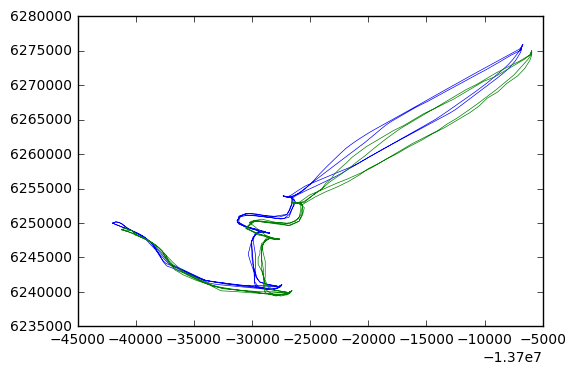

In [8]:
# Plot of all the route data
plt.plot(mt_data['cart_x'], mt_data['cart_y'],'-',linewidth=0.5, color = 'blue')
plt.plot(bc_route_data['cart_x'], bc_route_data['cart_y'],'-',linewidth=0.5, color ='green')
plt.show()

In [9]:
# January 11 meeting
# print affine_solver_in.head()
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.vstack.html#numpy.vstack
# http://gis.stackexchange.com/questions/30559/how-to-compute-parameters-for-qgis-affine-transformation

#Althernative approach
#http://stackoverflow.com/questions/22954239/given-three-points-compute-affine-transformation

#http://physics.stackexchange.com/questions/17509/what-is-the-physical-meaning-of-the-affine-parameter-for-null-geodesic
def solve_affine(df):
    '''
        Input dataframe must have 'sx', 'sy', 'tx','ty' columns
    '''
    n = len(df)
    zeros = np.zeros((n, 3))
    ones = np.ones((n,1))
    source_x = np.array(df['sx'].as_matrix(), ndmin = 2).transpose()
    source_y = np.array(df['sy'].as_matrix(), ndmin = 2).transpose()
    source_upper = np.hstack((source_x, source_y, ones, zeros))
    source_lower = np.hstack((zeros, source_x, source_y, ones))
    source = np.vstack((source_upper, source_lower))
    target_x = np.array(df['tx'].as_matrix(), ndmin = 2).transpose()
    target_y = np.array(df['ty'].as_matrix(), ndmin = 2).transpose()
    target = np.vstack((target_x, target_y))

    affine = np.linalg.lstsq(source,target)
    # print affine
    a,b,c,d,e,f = affine[0].tolist()
    new_affine = [a[0],b[0], c[0], d[0],e[0],f[0]]
    print a[0],',', b[0],',', c[0],',', d[0],',', e[0],',', f[0]
    return new_affine

In [10]:

def return_affine(route_tif):
        ds = gdal.Open(route_tif)
        c, a, b, f, d, e = ds.GetGeoTransform()
        print a,',', b,',', c,',', d,',', e,',', f
return_affine(route_file)



152.81406833 , 0.0 , -13767604.4713 , 0.0 , -152.81406833 , 6296772.42153


In [11]:

# cummulative distance calculation
# http://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas/29546836#29546836

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km



In [12]:

def affine_input_generator(df_bc, df_mt):
    affine_solver_in = pd.DataFrame(columns=('lon_s', 'lat_s', 'lon_t', 'lat_t', 'sx', 'sy', 'tx', 'ty','d')) # data frame on which the affine solver is going to work on

    for i in range(len(df_bc)):
        source_lon = df_bc.iloc[[i]].iat[0,15]
        source_lat = df_bc.iloc[[i]].iat[0,16]
        target_lon = df_mt.iloc[[i]].iat[0,1]
        target_lat = df_mt.iloc[[i]].iat[0,0]
        source_x = df_bc.iloc[[i]].iat[0,9]
        source_y = df_bc.iloc[[i]].iat[0,10]
        target_x = df_mt.iloc[[i]].iat[0,8]
        target_y = df_mt.iloc[[i]].iat[0,9]

        d = haversine_np(source_lon, source_lat, target_lon, target_lat)
        # if d < 1.0:
        affine_solver_in.loc[i] = [source_lon, source_lat, target_lon, target_lat, source_x, source_y, target_x, target_y, d]
    return affine_solver_in



In [13]:
# Finding corrospondances
bc_copy = bc_route_data.set_index(['Time'])
bc_data = bc_route_data[['Time','Last Update','lon', 'lat', 'cart_x', 'cart_y']].set_index('Time')
bc_data.index.name = None

mt_copy = mt_data.set_index(['timestamp'])
new_index = pd.concat([mt_copy.index.to_series(), bc_route_data["Last Update"].drop_duplicates()]).reset_index()[0].sort_values()
mt_reindexed = mt_copy.copy()
mt_reindexed = mt_reindexed.reindex(new_index).interpolate(method='time')

In [14]:
# df.idxmin(axis=0,skipna=True)
# np.argmin(np.abs(df.column - image_time))
# http://stackoverflow.com/questions/15115547/find-closest-row-of-dataframe-to-given-time-in-pandas?answertab=votes#tab-top

bc_time = pd.DataFrame()
bc_time['time'] = bc_route_data['Last Update']


bc_reindexed = pd.DataFrame(columns=bc_route_data.columns,index=bc_route_data.index, dtype= bc_route_data.dtypes)

for i in range(len(mt_reindexed)):
    n = np.argmin(np.abs(bc_time.time - mt_reindexed.index[i]))
    bc_reindexed.iloc[i] = bc_route_data.iloc[n]
    
bc_reindexed = bc_reindexed.dropna()
    
print bc_reindexed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1153 entries, 0 to 1152
Data columns (total 19 columns):
Destination    1153 non-null object
Heading        1153 non-null object
Last Update    1153 non-null object
Status         1153 non-null object
Time           1153 non-null object
Timezone       1153 non-null object
Vessel         1153 non-null object
route_no       1153 non-null object
speed          1153 non-null object
cx             1153 non-null object
cy             1153 non-null object
x1             1153 non-null object
x2             1153 non-null object
y1             1153 non-null object
y2             1153 non-null object
lon            1153 non-null object
lat            1153 non-null object
cart_x         1153 non-null object
cart_y         1153 non-null object
dtypes: object(19)
memory usage: 180.2+ KB
None


In [15]:
# after reindexing, the datatypes willbe set to object. we need to convert them into float to work for the affine solver.
bc_reindexed['lon'] = bc_reindexed['lon'].astype('float64')
bc_reindexed['lat'] = bc_reindexed['lat'].astype('float64')
bc_reindexed['cart_x'] = bc_reindexed['cart_x'].astype('float64')
bc_reindexed['cart_y'] = bc_reindexed['cart_y'].astype('float64')
mt_reindexed['lon'] = mt_reindexed['lon'].astype('float64')
mt_reindexed['lat'] = mt_reindexed['lat'].astype('float64')

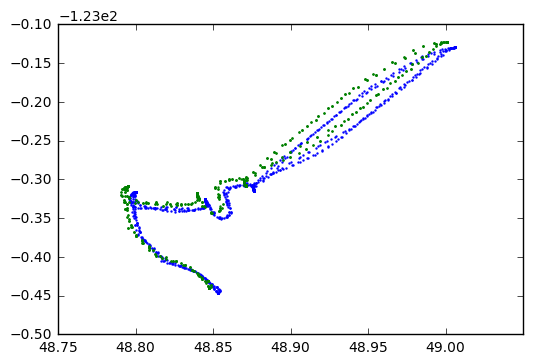

In [16]:
# Plot to visualize the corrospondances.
plt.scatter(mt_reindexed['lon'], mt_reindexed['lat'], color ='blue', s= 0.5)
plt.scatter(bc_reindexed['lon'], bc_reindexed['lat'], color ='green', s= 0.5)
plt.show()

In [17]:
# compute input df
input_df = affine_input_generator(bc_reindexed, mt_reindexed)

In [18]:

# drop the nans in the dataframe. otherwise a low level internal error will raise in the solve_affine()
input_df = input_df.dropna()
# input_df.describe()

In [19]:
# The real deal
new_affine = solve_affine(input_df)
print 'route file: ', return_affine(route_file)

151.410488477 , -1.09399405563 , -13767618.0045 , -0.638451935563 , -153.226431684 , 6297920.48101
route file:  152.81406833 , 0.0 , -13767604.4713 , 0.0 , -152.81406833 , 6296772.42153
None


In [20]:
# verify affine visually
# Recompute the lon and lat using the new affine parameters. witht eh pixels_to_coordinates() function

new_bc_data = bc_route_data.copy()

new_bc_data['lon'] = new_bc_data.apply(lambda x: pixels_to_coordinates(x,route_file,0,affine= new_affine), axis = 1)
new_bc_data['lat'] = new_bc_data.apply(lambda x: pixels_to_coordinates(x,route_file,1,affine = new_affine), axis = 1)
new_bc_data['cart_x'] = new_bc_data.apply(lambda x: pixels_to_coordinates(x,route_file,2,affine = new_affine), axis = 1)
new_bc_data['cart_y'] = new_bc_data.apply(lambda x: pixels_to_coordinates(x,route_file,3,affine = new_affine), axis = 1)


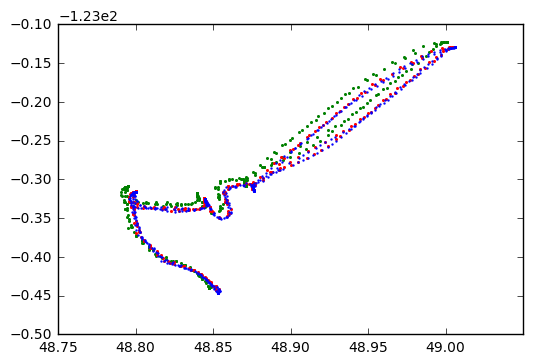

In [21]:
plt.scatter(bc_route_data['lon'], bc_route_data['lat'], color ='green', s= 0.5)
plt.scatter(new_bc_data['lon'], new_bc_data['lat'], color = 'red', s = 0.5)
plt.scatter(mt_data['lon'], mt_data['lat'], color='blue', s=0.5)
plt.show()